In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau


from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Concatenate


from IPython.display import FileLink
import os
import imageio.v2 as imageio  

In [2]:
#initial parameters
n = 1000
RV = np.arange(-18000,18001,500)

In [3]:
data_matrices = {}

for i in range(n):
    filename = f'STARSIM_output_CCFr_{i}.txt'
    data_matrix = np.loadtxt(filename)
    data_matrices[f'd{i}'] = data_matrix


In [4]:
for i in range(n):
    data_matrices[f'd{i}'] = data_matrices[f'd{i}'][:,1:]
    

In [5]:
for i in range(n):
    data_matrices[f'd{i}'] = data_matrices[f'd{i}'].T

In [8]:
image_filenames = []

jet=plt.get_cmap('rainbow')
colors = iter(jet(np.linspace(0,1,27)))

CCF= data_matrices['d1']/0.1

for j in range(27):
  plt.plot(RV[:], CCF[j,:], color=next(colors))  
  plt.xlabel('RV')
  plt.ylabel('diff CCF')
  plt.ylim((0,12.5))
  plt.title(f'Time Step {j}')
  filename = f'plot_{j}.png'
  plt.savefig(filename)
  plt.close() 
  image_filenames.append(filename)
with imageio.get_writer('CCF_original.gif', mode='I') as writer:
    for filename in image_filenames:
        image = imageio.imread(filename)
        for _ in range(int(2)):
            writer.append_data(image)
for filename in image_filenames:
   os.remove(filename)

FileLink('CCF_original.gif')


C:\Users\jenni\starsim\new_data_1period\long\CCF_original.gif

Compute differentials

In [6]:
ccf_total = {}

In [7]:
np.shape(data_matrices['d0'])

(27, 73)

In [8]:
for i in range(n):
    for j in range(73):
        a = 0
        for k in range(27):
            a += data_matrices[f'd{i}'][k,j]
        ccf_total[f'd{i}',j] = a
    

for i in range(n):
    ccf_total1 = np.zeros(73)
    for k in range(27):
        for j in range(73):
            ccf_total1[j] = ccf_total[f'd{i}',j]/27
        for l in range(73):
            data_matrices[f'd{i}'][k,l] = data_matrices[f'd{i}'][k,l]- ccf_total1[l]


In [9]:
for i in range(n):
    data_matrices[f'd{i}']=data_matrices[f'd{i}']/0.1
    
for i in range(n):
    data_matrices[f'd{i}'] = np.reshape(data_matrices[f'd{i}'],27*73)

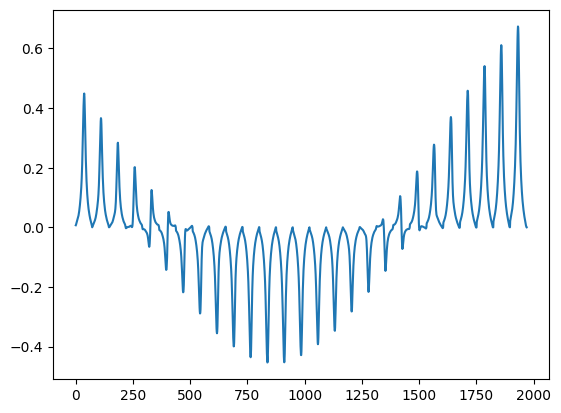

In [31]:
plt.plot(np.arange(0,73*27,1), data_matrices['d10'])

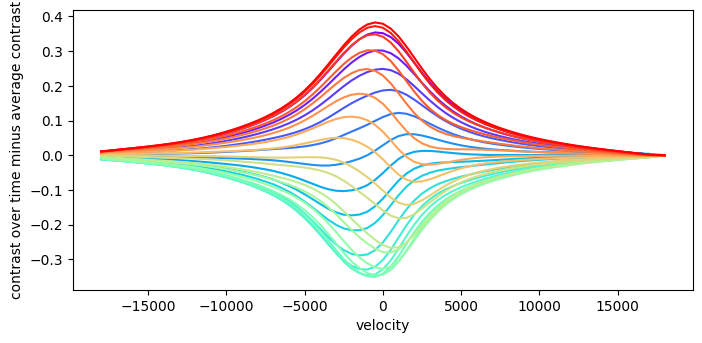

In [15]:
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot2grid((2, 1), (0, 0))
differential = data_matrices['d0']

jet=plt.get_cmap('rainbow')
colors = iter(jet(np.linspace(0,1,27)))

for j in range(27):
    ax1.plot(RV[:], differential[j,:], color=next(colors))
    ax1.set_ylabel('contrast over time minus average contrast')
    ax1.set_xlabel('velocity')

In [16]:
image_filenames = []

jet=plt.get_cmap('rainbow')
colors = iter(jet(np.linspace(0,1,27)))

for j in range(27):
  plt.plot(RV[:], differential[j,:], color=next(colors))  
  plt.xlabel('RV')
  plt.ylabel('diff CCF')
  plt.title(f'Time Step {j}')
  filename = f'plot_{j}.png'
  plt.savefig(filename)
  plt.close() 
  image_filenames.append(filename)
with imageio.get_writer('differential_original.gif', mode='I') as writer:
    for filename in image_filenames:
        image = imageio.imread(filename)
        for _ in range(int(2)):
            writer.append_data(image)
for filename in image_filenames:
   os.remove(filename)

In [17]:
FileLink('differential_original.gif')

C:\Users\jenni\starsim\new_data_1period\long\differential_original.gif

In [10]:
n_train = int(n*0.9*0.9)
n_val = int(n*0.9*0.1)
n_test = n-n_val-n_train
train_data = []
val_data = []
test_data = []

In [11]:
n_test

100

In [11]:
for i in range(n_train):
    train_data.append(data_matrices[f'd{i}'])

for i in range(n_train,n_train+n_val,1):
    val_data.append(data_matrices[f'd{i}'])
    
for i in range(n_train+n_val,n,1):
    test_data.append(data_matrices[f'd{i}'])

In [21]:
np.shape(test_data)

(8, 27, 73)

In [12]:
train_data = np.array(train_data).reshape(n_train,27*73)
val_data = np.array(val_data).reshape(n_val,27*73)
test_data = np.array(test_data).reshape(n_test, 27*73)

In [22]:
train2 = train_data[0,:].reshape(27,73)

In [23]:
image_filenames = []

jet=plt.get_cmap('rainbow')
colors = iter(jet(np.linspace(0,1,27)))

for j in range(27):
  plt.plot(RV[:], train2[j,:], color=next(colors))  
  plt.xlabel('RV')
  plt.ylabel('diff CCF')
  plt.title(f'Time Step {j}')
  plt.ylim((-0.65,0.3))
  filename = f'plot_{j}.png'
  plt.savefig(filename)
  plt.close() 
  image_filenames.append(filename)
with imageio.get_writer('differential_prova_train.gif', mode='I') as writer:
    for filename in image_filenames:
        image = imageio.imread(filename)
        for _ in range(int(2)):
            writer.append_data(image)
for filename in image_filenames:
   os.remove(filename)

FileLink('differential_prova_train.gif')

C:\Users\jenni\starsim\new_data_1period\long\differential_prova_train.gif

In [34]:
latent_dims = np.arange(1,21,1)
lossesvecval = []


for i in range(len(latent_dims)):
    class Autoencoder(Model):
        def __init__(self, latent_dim):
            super(Autoencoder, self).__init__()
            self.latent_dim = latent_dims[i]
            self.encoder = tf.keras.Sequential([
            layers.Dense(27*73, activation='linear'),
              layers.Dense(200, activation='relu'),
              layers.Dense(20, activation='relu'),
              layers.Dense(latent_dims[i], activation='relu'),
              ])
            self.decoder = tf.keras.Sequential([
                layers.Dense(20, activation='relu'),
                layers.Dense(200, activation='relu'),
                layers.Dense(27*73, activation='linear'),
              ])

        def call(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded


    autoencoder = Autoencoder(latent_dim=latent_dims[i])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-8)

    initial_learning_rate = 0.1
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                  loss='mse')

    optimizer = tf.keras.optimizers.Adam()


    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


    history = autoencoder.fit(train_data, train_data,
                              epochs=50,
                              shuffle=True,
                              batch_size=64,
                              validation_data=(val_data, val_data),
                               callbacks=[reduce_lr, early_stopping])

    last_epoch_loss2 = np.min(history.history['val_loss'])
    lossesvecval.append(last_epoch_loss2)


Epoch 1/50
13/13 [==============================] - 2s 39ms/step - loss: 0.0364 - val_loss: 0.0081 - lr: 0.1000
Epoch 2/50
13/13 [==============================] - 0s 23ms/step - loss: 0.0087 - val_loss: 0.0073 - lr: 0.1000
Epoch 3/50
13/13 [==============================] - 0s 23ms/step - loss: 0.0084 - val_loss: 0.0071 - lr: 0.1000
Epoch 4/50
13/13 [==============================] - 0s 21ms/step - loss: 0.0083 - val_loss: 0.0071 - lr: 0.1000
Epoch 5/50
13/13 [==============================] - 0s 20ms/step - loss: 0.0083 - val_loss: 0.0071 - lr: 0.1000
Epoch 6/50
13/13 [==============================] - 0s 19ms/step - loss: 0.0084 - val_loss: 0.0076 - lr: 0.1000
Epoch 7/50
13/13 [==============================] - 0s 19ms/step - loss: 0.0083 - val_loss: 0.0071 - lr: 0.1000
Epoch 8/50
13/13 [==============================] - 0s 20ms/step - loss: 0.0083 - val_loss: 0.0071 - lr: 0.1000
Epoch 9/50
13/13 [==============================] - 0s 22ms/step - loss: 0.0083 - val_loss: 0.0071 - lr:

Epoch 29/50
13/13 [==============================] - 0s 21ms/step - loss: 0.0082 - val_loss: 0.0071 - lr: 1.0000e-05
Epoch 1/50
13/13 [==============================] - 1s 38ms/step - loss: 25.0540 - val_loss: 0.0088 - lr: 0.1000
Epoch 2/50
13/13 [==============================] - 0s 22ms/step - loss: 0.0100 - val_loss: 0.0079 - lr: 0.1000
Epoch 3/50
13/13 [==============================] - 0s 23ms/step - loss: 0.0091 - val_loss: 0.0079 - lr: 0.1000
Epoch 4/50
13/13 [==============================] - 0s 24ms/step - loss: 0.0088 - val_loss: 0.0073 - lr: 0.1000
Epoch 5/50
13/13 [==============================] - 0s 23ms/step - loss: 0.0087 - val_loss: 0.0075 - lr: 0.1000
Epoch 6/50
13/13 [==============================] - 0s 24ms/step - loss: 0.0089 - val_loss: 0.0077 - lr: 0.1000
Epoch 7/50
13/13 [==============================] - 0s 23ms/step - loss: 0.0087 - val_loss: 0.0092 - lr: 0.1000
Epoch 8/50
13/13 [==============================] - 0s 24ms/step - loss: 0.0091 - val_loss: 0.0093

Epoch 7/50
13/13 [==============================] - 0s 22ms/step - loss: 0.3762 - val_loss: 0.3791 - lr: 0.1000
Epoch 8/50
13/13 [==============================] - 0s 20ms/step - loss: 0.3761 - val_loss: 0.3791 - lr: 0.0100
Epoch 9/50
13/13 [==============================] - 0s 21ms/step - loss: 0.3761 - val_loss: 0.3790 - lr: 0.0100
Epoch 10/50
13/13 [==============================] - 0s 20ms/step - loss: 0.3760 - val_loss: 0.3790 - lr: 0.0100
Epoch 11/50
13/13 [==============================] - 0s 23ms/step - loss: 0.3760 - val_loss: 0.3789 - lr: 0.0100
Epoch 12/50
13/13 [==============================] - 0s 21ms/step - loss: 0.3759 - val_loss: 0.3788 - lr: 0.0100
Epoch 1/50
13/13 [==============================] - 1s 36ms/step - loss: 12778.3447 - val_loss: 0.1181 - lr: 0.1000
Epoch 2/50
13/13 [==============================] - 0s 20ms/step - loss: 0.0691 - val_loss: 0.0100 - lr: 0.1000
Epoch 3/50
13/13 [==============================] - 0s 23ms/step - loss: 0.0264 - val_loss: 0.009

13/13 [==============================] - 0s 25ms/step - loss: 0.0082 - val_loss: 0.0071 - lr: 1.0000e-04
Epoch 42/50
13/13 [==============================] - 0s 27ms/step - loss: 0.0082 - val_loss: 0.0071 - lr: 1.0000e-04
Epoch 43/50
13/13 [==============================] - 0s 24ms/step - loss: 0.0082 - val_loss: 0.0071 - lr: 1.0000e-04
Epoch 44/50
13/13 [==============================] - 0s 24ms/step - loss: 0.0082 - val_loss: 0.0071 - lr: 1.0000e-05
Epoch 45/50
13/13 [==============================] - 0s 23ms/step - loss: 0.0082 - val_loss: 0.0071 - lr: 1.0000e-05
Epoch 46/50
13/13 [==============================] - 0s 23ms/step - loss: 0.0082 - val_loss: 0.0071 - lr: 1.0000e-05
Epoch 1/50
13/13 [==============================] - 1s 40ms/step - loss: 2437.4607 - val_loss: 0.0112 - lr: 0.1000
Epoch 2/50
13/13 [==============================] - 0s 21ms/step - loss: 0.0117 - val_loss: 0.0110 - lr: 0.1000
Epoch 3/50
13/13 [==============================] - 0s 24ms/step - loss: 0.0103 - v

Epoch 11/50
13/13 [==============================] - 0s 23ms/step - loss: 0.0096 - val_loss: 0.0082 - lr: 0.1000
Epoch 12/50
13/13 [==============================] - 0s 23ms/step - loss: 0.0089 - val_loss: 0.0075 - lr: 0.1000
Epoch 13/50
13/13 [==============================] - 0s 23ms/step - loss: 0.0084 - val_loss: 0.0072 - lr: 0.0100
Epoch 14/50
13/13 [==============================] - 0s 24ms/step - loss: 0.0083 - val_loss: 0.0072 - lr: 0.0100
Epoch 15/50
13/13 [==============================] - 0s 24ms/step - loss: 0.0083 - val_loss: 0.0071 - lr: 0.0100
Epoch 16/50
13/13 [==============================] - 0s 26ms/step - loss: 0.0082 - val_loss: 0.0071 - lr: 0.0100
Epoch 17/50
13/13 [==============================] - 0s 30ms/step - loss: 0.0083 - val_loss: 0.0071 - lr: 0.0100
Epoch 18/50
13/13 [==============================] - 0s 28ms/step - loss: 0.0082 - val_loss: 0.0071 - lr: 1.0000e-03
Epoch 19/50
13/13 [==============================] - 0s 29ms/step - loss: 0.0082 - val_loss:

13/13 [==============================] - 0s 22ms/step - loss: 0.0082 - val_loss: 0.0071 - lr: 1.0000e-03
Epoch 20/50
13/13 [==============================] - 0s 22ms/step - loss: 0.0082 - val_loss: 0.0071 - lr: 1.0000e-03
Epoch 21/50
13/13 [==============================] - 0s 22ms/step - loss: 0.0082 - val_loss: 0.0071 - lr: 1.0000e-03
Epoch 22/50
13/13 [==============================] - 0s 22ms/step - loss: 0.0082 - val_loss: 0.0071 - lr: 1.0000e-03
Epoch 23/50
13/13 [==============================] - 0s 22ms/step - loss: 0.0082 - val_loss: 0.0071 - lr: 1.0000e-04
Epoch 24/50
13/13 [==============================] - 0s 23ms/step - loss: 0.0082 - val_loss: 0.0071 - lr: 1.0000e-04
Epoch 25/50
13/13 [==============================] - 0s 22ms/step - loss: 0.0082 - val_loss: 0.0071 - lr: 1.0000e-04
Epoch 26/50
13/13 [==============================] - 0s 22ms/step - loss: 0.0082 - val_loss: 0.0071 - lr: 1.0000e-04
Epoch 27/50
13/13 [==============================] - 0s 23ms/step - loss: 0.

In [147]:
latent_dims = [10]
lossesvecval2 = []


for i in range(len(latent_dims)):
    class Autoencoder(Model):
        def __init__(self, latent_dim):
            super(Autoencoder, self).__init__()
            self.latent_dim = latent_dims[i]
            self.encoder = tf.keras.Sequential([
            layers.Dense(27*73, activation='linear'),
              layers.Dense(200, activation='relu'),
              layers.Dense(20, activation='relu'),
              layers.Dense(latent_dims[i], activation='relu'),
              ])
            self.decoder = tf.keras.Sequential([
                layers.Dense(20, activation='relu'),
                layers.Dense(200, activation='relu'),
                layers.Dense(27*73, activation='linear'),
              ])

        def call(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded


    autoencoder = Autoencoder(latent_dim=latent_dims[i])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5)

    initial_learning_rate = 0.1
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                  loss='mse')

    optimizer = tf.keras.optimizers.Adam()


    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


    history = autoencoder.fit(train_data, train_data,
                              epochs=50,
                              shuffle=True,
                              batch_size=32,
                              validation_data=(val_data, val_data),
                               callbacks=[reduce_lr, early_stopping])

    last_epoch_loss2 = np.min(history.history['val_loss'])
    lossesvecval2.append(last_epoch_loss2)


Epoch 1/50
26/26 [==============================] - 1s 24ms/step - loss: 99370.9062 - val_loss: 0.0121 - lr: 0.1000
Epoch 2/50
26/26 [==============================] - 0s 17ms/step - loss: 0.0117 - val_loss: 0.0123 - lr: 0.1000
Epoch 3/50
26/26 [==============================] - 0s 17ms/step - loss: 0.0092 - val_loss: 0.0072 - lr: 0.1000
Epoch 4/50
26/26 [==============================] - 0s 16ms/step - loss: 0.0087 - val_loss: 0.0080 - lr: 0.1000
Epoch 5/50
26/26 [==============================] - 0s 16ms/step - loss: 0.0088 - val_loss: 0.0072 - lr: 0.1000
Epoch 6/50
26/26 [==============================] - 0s 16ms/step - loss: 0.0087 - val_loss: 0.0082 - lr: 0.1000
Epoch 7/50
26/26 [==============================] - 0s 16ms/step - loss: 0.0088 - val_loss: 0.0099 - lr: 0.1000
Epoch 8/50
26/26 [==============================] - 0s 17ms/step - loss: 0.0088 - val_loss: 0.0073 - lr: 0.1000
Epoch 9/50
26/26 [==============================] - 0s 16ms/step - loss: 0.0083 - val_loss: 0.0072 -

In [148]:
lossesvecval[9]= lossesvecval2[0]


(0.0, 0.0075)

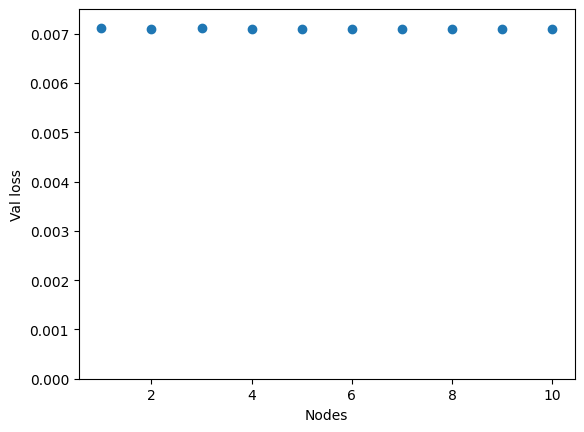

In [156]:
plt.scatter(np.arange(1,11,1),lossesvecval)
plt.xlabel('Nodes')
plt.ylabel('Val loss')
plt.ylim((0,0.0075))

In [150]:
lossesvecval

[0.007121213246136904,
 0.007095192559063435,
 0.007108981255441904,
 0.007103996817022562,
 0.007102313917130232,
 0.0070932903327047825,
 0.007095601875334978,
 0.007099435664713383,
 0.007101512514054775,
 0.007091840263456106]

In [22]:
latent_dim = 60
lossesvecval = []
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
    layers.Dense(27*73, activation='linear'),
          layers.Dense(500, activation='relu'),
          layers.Dense(100, activation='relu'),
          layers.Dense(latent_dim, activation='relu'),
          ])
    self.decoder = tf.keras.Sequential([
            layers.Dense(100, activation='relu'),
            layers.Dense(500, activation='relu'),
            layers.Dense(27*73, activation='linear'),
          ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


autoencoder = Autoencoder(latent_dim)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-8)

initial_learning_rate = 0.1
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss='mse')

optimizer = tf.keras.optimizers.Adam()


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = autoencoder.fit(train_data, train_data,
                          epochs=50,
                          shuffle=True,
                          batch_size=32,
                          validation_data=(val_data, val_data),
                           callbacks=[reduce_lr, early_stopping])


Epoch 1/50
26/26 [==============================] - 4s 79ms/step - loss: 12068954112.0000 - val_loss: 7.9426 - lr: 0.1000
Epoch 2/50
26/26 [==============================] - 1s 36ms/step - loss: 68268000.0000 - val_loss: 16.3834 - lr: 0.1000
Epoch 3/50
26/26 [==============================] - 1s 38ms/step - loss: 1217627815936.0000 - val_loss: 3.4159 - lr: 0.1000
Epoch 4/50
26/26 [==============================] - 1s 35ms/step - loss: 15.9548 - val_loss: 39.7001 - lr: 0.1000
Epoch 5/50
26/26 [==============================] - 1s 37ms/step - loss: 47.1597 - val_loss: 50.2817 - lr: 0.1000
Epoch 6/50
26/26 [==============================] - 1s 39ms/step - loss: 49.1530 - val_loss: 47.0659 - lr: 0.1000
Epoch 7/50
26/26 [==============================] - 1s 35ms/step - loss: 43.7832 - val_loss: 39.1010 - lr: 0.1000
Epoch 8/50
26/26 [==============================] - 1s 36ms/step - loss: 32.9610 - val_loss: 24.9665 - lr: 0.1000
Epoch 9/50
26/26 [==============================] - 1s 35ms/step

In [19]:
test_pred = np.reshape(test_data[1,:], (1,27*73))
predictions = autoencoder.predict(test_pred)
predictions = np.reshape(predictions, (27*73))

1/1 [==============================] - 0s 292ms/step


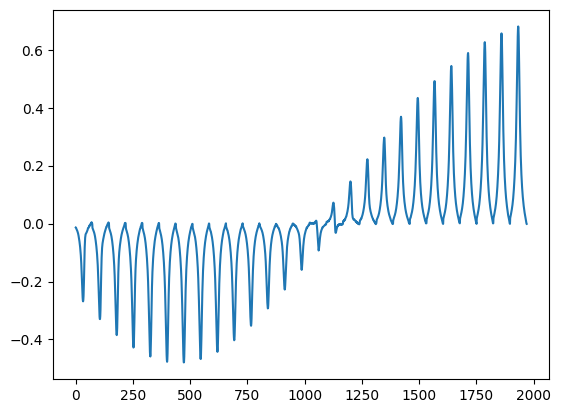

In [24]:
plt.plot(np.arange(0,73*27,1), predictions)

In [20]:
predictions = np.reshape(predictions, (27,73))

In [21]:
jet=plt.get_cmap('rainbow')
colors=iter(jet(np.linspace(0,0.5,27)))
colors1=iter(jet(np.linspace(0.5,1,27)))
test2 = test_data[1,:].reshape(27,73)


image_filenames2 = []
for j in range(27):
  plt.plot(RV[:], predictions[j,:], color=next(colors), linestyle='dashed') 
  plt.plot(RV[:], test2[j,:], color='red')  
  plt.xlabel('RV')
  plt.ylabel('CCF')
  plt.title(f'Time Step {j}')
  filename = f'plot_{j}.png'
  plt.savefig(filename)
  plt.close() 
  image_filenames2.append(filename)
with imageio.get_writer('plotsTest_pred.gif', mode='I') as writer:
  for filename in image_filenames2:
    image = imageio.imread(filename)
    writer.append_data(image)

for filename in image_filenames2:
   os.remove(filename)

FileLink('plotsTest_pred.gif')


C:\Users\jenni\starsim\new_data_1period\1CCF\plotsTest_pred.gif